In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle


In [2]:
# parameters
filename = 'gb1'
wildtype = "MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE"

# load into dataframe
df = pd.read_csv(f'{filename}.tsv', sep='\t')
# print(df.columns)

# Function to apply mutations to the wildtype sequence
def apply_mutations(wildtype, mutations):
    # Convert the wildtype string into a list for mutability
    sequence_list = list(wildtype)
    for mutation in mutations.split(','):
        pos = int(mutation[1:-1])  # Convert to 0-based index
        mut_residue = mutation[-1]
        sequence_list[pos] = mut_residue  # Apply the mutation
    return ''.join(sequence_list)

# Function to adjust mutation indexing for the mutations column
def adjust_mutation_indexing(mutation):
    parts = mutation.split(',')
    adjusted_mutations = []
    for part in parts:
        # Split each mutation into its components
        original_aa = part[0]
        position = int(part[1:-1])
        mutated_aa = part[-1]
        # Adjust position by adding 1
        adjusted_position = position + 1
        adjusted_mutations.append(f"{original_aa}{adjusted_position}{mutated_aa}")
    return ','.join(adjusted_mutations)

# Apply mutations to generate sequences
df['sequence'] = df['variant'].apply(lambda x: apply_mutations(wildtype, x))

# Adjust mutations column to reflect new indexing
df['mutations'] = df['variant'].apply(adjust_mutation_indexing)

# Rename columns
df.rename(columns={'score': 'functional_score'}, inplace=True)

# Select and reorder the relevant columns
df = df[['sequence', 'mutations', 'num_mutations', 'functional_score']]

# Save the processed DataFrame to a pickle file
df.to_pickle('SeqFxnDataset.pkl')


In [3]:
df.head()

,sequence,mutations,num_mutations,functional_score
0,MAYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,Q2A,1,0.417326
1,MCYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,Q2C,1,0.024091
2,MDYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,Q2D,1,-0.093596
3,MEYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,Q2E,1,-0.049649
4,MFYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,Q2F,1,0.480394


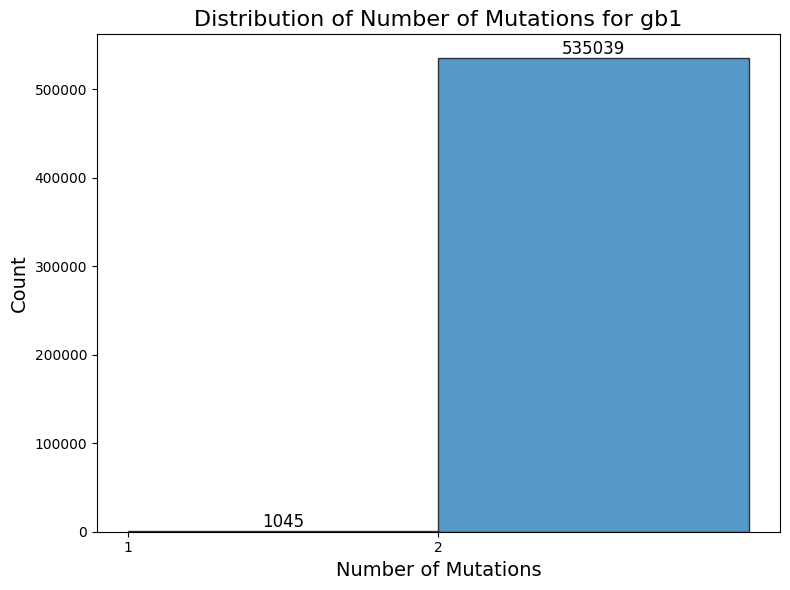

In [4]:
num_mutations = df['num_mutations']

# Determine the range for integer bins based on the data
min_mut = int(num_mutations.min())
max_mut = int(num_mutations.max())

# Create integer bins for each mutational regime
bins = np.arange(min_mut, max_mut + 2)  # +2 to include the last edge
plt.figure(figsize=(8, 6))
counts, bins, patches = plt.hist(num_mutations, bins=bins, edgecolor='black', alpha=0.75)

# Formatting the plot
plt.xlabel('Number of Mutations', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title(f'Distribution of Number of Mutations for {filename}', fontsize=16)
plt.xticks(np.arange(min_mut, max_mut + 1))
# Annotate each bar with the count
for count, patch in zip(counts, patches):
    x_center = patch.get_x() + patch.get_width() / 2
    plt.text(x_center, patch.get_height(), int(count), ha='center', va='bottom', fontsize=12)

# Adjust layout and save the figure
output_filename = f'{filename}_num_mutations_histogram.png'
plt.tight_layout()
plt.savefig(output_filename)
plt.show()


In [7]:
# Setup thresholds
num_muts_threshold = 1
num_muts_of_val_test_splits = 2  # Specifically for training, validation, and test splits
percent_validation_split = 15  # Percentage of data going to validation

# Create indices lists
train_indices = []
val_indices = []
test_indices = []

# Split logic based on mutation count
train_indices.extend(df[df['num_mutations'] <= num_muts_threshold].index.tolist())

# Handling more complex scenarios, such as exact counts for splits
if num_muts_of_val_test_splits:
    complex_mut_indices = df[df['num_mutations'] == num_muts_of_val_test_splits].index.tolist()
    random.shuffle(complex_mut_indices)
    
    # Calculate indices for 50% of the data with exactly 2 mutations
    half_complex_mut_indices = complex_mut_indices[:len(complex_mut_indices) // 2]
    split_val = int(len(half_complex_mut_indices) * (percent_validation_split / 100))
    split_test = int(len(half_complex_mut_indices) * 0.05)
    val_indices.extend(half_complex_mut_indices[:split_val])
    test_indices.extend(half_complex_mut_indices[split_val:split_val + split_test])
    train_indices.extend(half_complex_mut_indices[split_val + split_test:])

# Shuffle indices to ensure random distribution
random.shuffle(train_indices)
random.shuffle(val_indices)
random.shuffle(test_indices)

# Optionally, store the indices or the actual splits
def save_splits(path):
    with open(path, 'wb') as f:
        pickle.dump((train_indices, val_indices, test_indices), f)

# Example of saving splits
save_splits('SeqFxnDataset_splits.pkl')

# Printing some results to verify
print("Training indices count:", len(train_indices))
print("Validation indices count:", len(val_indices))
print("Test indices count:", len(test_indices))


Training indices count: 215062
Validation indices count: 40127
Test indices count: 13375
